# Prepare raw data for curvecurator

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pubchempy as pcp
from Bio.ExPASy import cellosaurus
import toml
from drevalpy.datasets.curvecurator import preprocess, _exec_curvecurator, postprocess

## Load Data

In [2]:
RAW_FILE_PATH = Path("CTRPv1.0_2013_pub_Cell_154_1151/v10.D2.avg_pct_viability_data.txt")

In [3]:
raw_df = pd.read_csv(RAW_FILE_PATH, sep='\t')
raw_df = raw_df.sort_values(["ccl_name", "cpd_name", "cpd_conc_umol"])
raw_df

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv
195409,5637,(-)-gallocatechin-3-monogallate,Cpd,0.2890,0.907442
195410,5637,(-)-gallocatechin-3-monogallate,Cpd,0.5780,0.903863
195411,5637,(-)-gallocatechin-3-monogallate,Cpd,1.1563,0.942774
195412,5637,(-)-gallocatechin-3-monogallate,Cpd,2.3123,0.899073
195413,5637,(-)-gallocatechin-3-monogallate,Cpd,4.6250,0.933793
...,...,...,...,...,...
46034,WSUDLCL2,zileuton,Cpd,33.3330,0.933906
46035,WSUDLCL2,zileuton,Cpd,66.6670,1.032896
46036,WSUDLCL2,zileuton,Cpd,133.3300,0.934276
46037,WSUDLCL2,zileuton,Cpd,266.6700,0.869657


## Prepare data

In [4]:
## fix low doses that are similar to the 6th digit
raw_df.loc[raw_df.cpd_conc_umol == 0.0040623, 'cpd_conc_umol'] = 0.0040625
raw_df.loc[raw_df.cpd_conc_umol == 0.0040627, 'cpd_conc_umol'] = 0.0040625

raw_df.loc[raw_df.cpd_conc_umol == 0.0020312, 'cpd_conc_umol'] = 0.00203125
raw_df.loc[raw_df.cpd_conc_umol == 0.0020313, 'cpd_conc_umol'] = 0.00203125

In [5]:
# make pubchem_cids to ints
drug_df = pd.read_csv("CTRPv1.0_2013_pub_Cell_154_1151/v10.M1.informer_set.txt", sep="\t")
drug_df["pubchem_cid"] = drug_df.pubchem_cid.fillna(-1).astype(int)

In [6]:
full_df = raw_df.merge(drug_df, on="cpd_name")

## Creating replicate information

In [7]:
full_df["maxdose"] = full_df.groupby(["ccl_name", "cpd_name"])["cpd_conc_umol"].transform("max")
full_df["mindose"] = full_df.groupby(["ccl_name", "cpd_name"])["cpd_conc_umol"].transform("min")
full_df["replicate"] = full_df.groupby(["cpd_conc_umol", "ccl_name", "cpd_name"]).cumcount() + 1
full_df["nreplicates"] = full_df.groupby(["ccl_name", "cpd_name"])["replicate"].transform("max")
full_df

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv,cpd_synonym,cpd_status,target_or_activity_of_compound,gene_symbol_of_protein_target,top_test_conc_umol,percent_cpd_purity,cpd_smiles,pubchem_cid,broad_cpd_id,master_cpd_id,maxdose,mindose,replicate,nreplicates
0,5637,(-)-gallocatechin-3-monogallate,Cpd,0.2890,0.907442,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.00,0.2890,1,1
1,5637,(-)-gallocatechin-3-monogallate,Cpd,0.5780,0.903863,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.00,0.2890,1,1
2,5637,(-)-gallocatechin-3-monogallate,Cpd,1.1563,0.942774,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.00,0.2890,1,1
3,5637,(-)-gallocatechin-3-monogallate,Cpd,2.3123,0.899073,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.00,0.2890,1,1
4,5637,(-)-gallocatechin-3-monogallate,Cpd,4.6250,0.933793,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.00,0.2890,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523804,WSUDLCL2,zileuton,Cpd,33.3330,0.933906,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,87.0,CC(N(O)C(=O)N)c1cc2ccccc2s1,60490,BRD-A56359832,346974,533.33,4.1667,1,1
523805,WSUDLCL2,zileuton,Cpd,66.6670,1.032896,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,87.0,CC(N(O)C(=O)N)c1cc2ccccc2s1,60490,BRD-A56359832,346974,533.33,4.1667,1,1
523806,WSUDLCL2,zileuton,Cpd,133.3300,0.934276,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,87.0,CC(N(O)C(=O)N)c1cc2ccccc2s1,60490,BRD-A56359832,346974,533.33,4.1667,1,1
523807,WSUDLCL2,zileuton,Cpd,266.6700,0.869657,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,87.0,CC(N(O)C(=O)N)c1cc2ccccc2s1,60490,BRD-A56359832,346974,533.33,4.1667,1,1


In [8]:
drug_dosages = full_df[["ccl_name", "cpd_name", "mindose", "maxdose"]].drop_duplicates()
drug_dosages.to_csv("drug_dosages_CTRPv1.csv", index=False)

## Drugname to PubChem mapping

In [8]:
full_df.query("pubchem_cid == -1")[["cpd_name", "broad_cpd_id","cpd_synonym", "cpd_smiles", "pubchem_cid"]].drop_duplicates()

,cpd_name,broad_cpd_id,cpd_synonym,cpd_smiles,pubchem_cid
24,"2,4-dideoxy-DC-45-A2",BRD-K41087962,NaN,COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(...,-1
104,6-diazo-5-oxo-L-norleucine,BRD-K84924563,diazooxonorleucine;DON;L-DON,N[C@@H](CCC(=O)C[N+]#N)C(=O)O,-1
264,BRD2649,BRD-K26312649,NaN,CNC[C@@H]1OCC=CC[C@@H](C)Oc2ccc(cc2C(=O)N(C[C@...,-1
312,BRD9786,BRD-K94679786,NaN,CC(C)N1C[C@@H](C)[C@H](CN(C)Cc2ccc3OCOc3c2)OCC...,-1
384,Compound 10b,BRD-K18190982,NaN,NC(=C)c1cc2c(cnc(N)c2s1)c3cccc(c3)c4ccccc4,-1
456,DC-45-A2,BRD-K79983625,NaN,COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(...,-1
816,PP-30,BRD-K30677119,NaN,CC(C)n1nc(c2cccc(c2)C(=O)NC3=NCCC3)c4c(N)ncnc14,-1
832,PRL-3 Inhibitor I,BRD-K09907482,NaN,Brc1ccc(OCc2ccccc2Br)c(\C=C/3\SC(=S)NC3=O)c1,-1
976,WT-161,BRD-K74761218,NaN,ONC(=O)CCCCCCC(=O)N\N=C\c1ccc(cc1)N(c2ccccc2)c...,-1
1256,iso-DC-45-A2,BRD-K51759822,NaN,COC(OC)[C@@]12O[C@H]3[C@H](O1)[C@](O)(Oc4c3c(C...,-1


In [9]:
for smile in full_df.query("pubchem_cid == -1")[["cpd_name", "cpd_synonym", "cpd_smiles", "pubchem_cid"]].drop_duplicates().cpd_smiles:
    print(smile)

COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(C)cc5c(OC)c6CCCC(=O)c6c(O)c45)[C@@]27CO7
N[C@@H](CCC(=O)C[N+]#N)C(=O)O
CNC[C@@H]1OCC=CC[C@@H](C)Oc2ccc(cc2C(=O)N(C[C@H]1C)[C@@H](C)CO)N(C)C
CC(C)N1C[C@@H](C)[C@H](CN(C)Cc2ccc3OCOc3c2)OCCCC[C@@H](C)Oc4ccc(cc4C1=O)N(C)C
NC(=C)c1cc2c(cnc(N)c2s1)c3cccc(c3)c4ccccc4
COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(C)cc5c(OC)c6[C@@H](O)C[C@H](O)C(=O)c6c(O)c45)[C@@]27CO7
CC(C)n1nc(c2cccc(c2)C(=O)NC3=NCCC3)c4c(N)ncnc14
Brc1ccc(OCc2ccccc2Br)c(\C=C/3\SC(=S)NC3=O)c1
ONC(=O)CCCCCCC(=O)N\N=C\c1ccc(cc1)N(c2ccccc2)c3ccccc3
COC(OC)[C@@]12O[C@H]3[C@H](O1)[C@](O)(Oc4c3c(C)cc5c(OC)c6[C@@H](O)C[C@H](O)C(=O)c6c(O)c45)[C@@]27CO7
COC(OC)C12OC3C(O1)C(O)(Oc4c3c(C)cc5c(OC)c6CCCC(=O)c6c(O)c45)C27CO7
CO[C@@H]1C[C@H](C[C@@H](C)[C@@H]2CC(=O)[C@H](C)\C=C(/C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(/C)\[C@H](CC3CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N4CCCC[C@H]4C(=O)O2)OC)CCC1O
CO[C@@H]1CC(CC[C@H]1O)\C=C(/C)\[C@H]2OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@]4(O)O[C@H]([C@H](CC(C

In [10]:
## via manual SMILES search in PubChem
results = {}
results['2,4-dideoxy-DC-45-A2'] = '73707381'
results['6-diazo-5-oxo-L-norleucine'] = '73707377'
results['BRD2649'] = 'BRD2649'                            # not found
results['BRD9786'] = 'BRD9786'                            # not found
results['Compound 10b'] = '73707373'
results['DC-45-A2'] = '73707376'
results['PP-30'] = '73707372'
results['PRL-3 Inhibitor I'] = '73707371'
results['WT-161'] = '121596287'
results['iso-DC-45-A2'] = 'iso-DC-45-A2'                  # not found
results['racemic-2,4-dideoxy-DC-45-A2'] = '126757334'
results['sirolimus'] = '5284616'                          # via name search, SMILES did not hit
results['tacrolimus'] = '445643'                          # via name search, SMILES did not hit
results['BRD2762'] = 'BRD2762'                            # not found
results['BRD5802'] = 'BRD5802'                            # not found
results['BRD6150'] = 'BRD6150'                            # not found
results['BRD9658'] = 'BRD9658'                            # not found

results['CIL55A'] = '168313047'
results['chaetocin'] = '137549100'
results['BRD2296'] = 'BRD2296'                            # not found
results['BRD9571'] = 'BRD9571'                            # not found
results['PL-DI'] = '73707398'
results['pandacostat'] = '136350280'
results['trans-C 75'] = '90488767'


## Cell line name to Cellosaurus Mapping

In [11]:
# Download Cellosaurus data in OBO format
#url = "ftp://ftp.expasy.org/databases/cellosaurus/cellosaurus.txt"
filename = "../../mapping/cellosaurus.txt"
#urllib.request.urlretrieve(url, filename)

In [12]:
cl_mappings = {}
btos = {}
with open(filename) as handle:
    records = cellosaurus.parse(handle)
    for record in records:
        if 'Homo sapiens' in record['OX'][0]:
            if record["ID"] not in cl_mappings:
                cl_mappings[record["ID"]] = []
            cl_mappings[record["ID"]].append(record["AC"])
            syns = record["SY"].split("; ")
            for syn in syns:
                if syn == '':
                    continue
                if syn not in cl_mappings:
                    cl_mappings[syn] = []
                cl_mappings[syn].append(record["AC"])
            for a, b in record["DR"]:
                if a == 'BTO':
                    if record["AC"] not in btos:
                        btos[record["AC"]] = []
                    btos[record["AC"]].append(b)

In [13]:
ccls = full_df["ccl_name"].unique()
mappings = {}
manual_checks = {}
for ccl in ccls:
    cellosaurus_ids = cl_mappings.get(ccl, [])
    if len(cellosaurus_ids) == 1:
        mappings[ccl] = cellosaurus_ids[0]
    else:
        manual_checks[ccl] = cellosaurus_ids

In [14]:
print("CCLs:", len(ccls), "matches:", len(mappings), "ambiguous:", len(manual_checks))

CCLs: 242 matches: 232 ambiguous: 10


In [15]:
manual_checks

{'COLO205': ['CVCL_0218', 'CVCL_F402'],
 'EBC1': ['CVCL_2891', 'CVCL_E218'],
 'G361': ['CVCL_1220', 'CVCL_C8ZL'],
 'HARA': [],
 'LP1': ['CVCL_0012', 'CVCL_SA54'],
 'OV7': ['CVCL_DG86', 'CVCL_2675'],
 'PC3': ['CVCL_C8XA', 'CVCL_4011', 'CVCL_0035', 'CVCL_S982', 'CVCL_4055'],
 'PL21': ['CVCL_2161', 'CVCL_JM48', 'CVCL_E295'],
 'RCM1': ['CVCL_C099', 'CVCL_1648'],
 'SCC9': ['CVCL_1685', 'CVCL_7793']}

In [16]:
manual_checks['COLO205'] = 'CVCL_0218'  # this is the one derived from an adenocarcinoma in a 70 year old white male, while the other one is a transformed cell line from a young female according to cellosaurus
manual_checks['EBC1'] = 'CVCL_2891'  # this is the squamous cell carcinoma according to cellosaurus
manual_checks['G361'] = 'CVCL_1220'  # this is the melanoma according to cellosaurus

manual_checks["HARA"] = 'CVCL_2914'  # this is HARA [Human squamous cell lung carcinoma]

manual_checks["LP1"] = 'CVCL_0012'  # this is the plasma cell myeloma according to cellosaurus
manual_checks["OV7"] = 'CVCL_2675'  # this is the ovarian carcinoma according to cellosaurus, kind of a best guess here

manual_checks["PC3"] = 'CVCL_0035'  # this is the pancreatic cancer according to cellosaurus
manual_checks["PL21"] = 'CVCL_2161'  # this is the accute myeloid leukemia according to cellosaurus

manual_checks["RCM1"] = 'CVCL_1648'  # this is RCM-1 [Human rectal adenocarcinoma], according to cellosaurus
manual_checks["SCC9"] = 'CVCL_1685'  # this is the tongue squamous cell carcinoma according to cellosaurus


In [17]:
rev_mapping = {}
for key, val in (mappings | manual_checks).items():
    if val not in rev_mapping:
        rev_mapping[val] = []
    rev_mapping[val].append(key)

In [18]:
any([len(val) != 1 for val in rev_mapping.values()])

False

In [19]:
len(rev_mapping)

242

In [20]:
mappings |= manual_checks

In [21]:
celline_mappings = pd.DataFrame.from_dict(mappings, orient='index')
celline_mappings.columns = ['CVCL']
btos_df = pd.DataFrame({'BTO': btos.values()}, index=btos.keys())

## Compare to Judith's mapping

In [22]:
celline_mappings = celline_mappings.reset_index()
celline_mappings = celline_mappings.rename(columns={"index": "cell_line_name"})

In [23]:
from utils.convert_to_cello import create_cl_dict, map_to_cellosaurus
cello_mapping = pd.read_csv("../../mapping/cellosaurus_01_2024.csv")
# replace all NaN values with empty strings
cello_mapping = cello_mapping.fillna("")
# create cellosaurus dictionary
cellosaurus_ac_dict, cellosaurus_sy_dict, species_dict, cello_ac_to_id_dict = create_cl_dict(cello_mapping)

mapping_df = celline_mappings.copy()
mapping_df["cell_line_original_name"] = mapping_df["cell_line_name"]
mapping_df["cell_line_name"] = mapping_df["cell_line_name"].replace({
    "BC3C": "BC-3C",
    "BT164": "BT 164",
    "BT147": "BT 147",
    "C32": "C32 [Human melanoma]",
    "CJM": "CJM [Human melanoma]",
    "COLO201": "COLO 201",
    "COLO205": "COLO 205",
    "ES2": "ES-2",
    "G361": "G-361",
    "HARA": "HARA [Human squamous cell lung carcinoma]",
    "HH": "HH [Human lymphoma]",
    "HT29": "HT-29",
    "HT55": "HT-55",
    "JK1": "JK-1",
    "JM1": "JM-1",
    "LK2": "LK-2",
    "MEC1": "MEC-1",
    "ME1": "ME-1 [Human leukemia]",
    "MINO": "Mino",
    "ML1": "ML-1 [Human thyroid carcinoma]",
    "NCIH2087": "NCI-H2087",
    "NCIH2444": "NCI-H2444",
    "PC3": "PC-3",
    "PL21": "PL-21",
    "PK1": "PK-1",
    "RCM1": "RCM-1 [Human rectal adenocarcinoma]",
    "SH4": "SH-4",
    "TC71": "TC-71",
    "TE1": "TE-1",
    "TE8": "TE-8",
    "TE15": "TE-15",
    "TTTHYROID": "TT"
})
map_to_cellosaurus(mapping_df, cellosaurus_ac_dict, cellosaurus_sy_dict, species_dict, cello_ac_to_id_dict, output_path="CCLE_mapped.csv")
mapping_df = pd.read_csv("CCLE_mapped.csv")
# find out where CVCL is not equal to cellosaurus_id
mapping_df.query("CVCL != cellosaurus_id")

Creating cellosaurus dictionary ...
Mapping cell line names to cellosaurus IDs ...
Saving dataframe with cellosaurus IDs ...


,cellosaurus_id,cell_line_name,CVCL,cell_line_original_name


In [24]:
btos_df

,BTO
CVCL_IP58,[BTO_0006002]
CVCL_IP59,[BTO_0006003]
CVCL_L211,[BTO_0005352]
CVCL_5948,[BTO_0002603]
CVCL_8030,[BTO_0002947]
...,...
CVCL_6746,[BTO_0003554]
CVCL_WY40,[BTO_0006281]
CVCL_5906,[BTO_0003992]
CVCL_0588,[BTO_0003136]


In [25]:
# filter relevant and check for more than one BTO mapping
cvcl_to_bto = celline_mappings.merge(btos_df, left_on='CVCL', right_index=True, how='left')#[:220]
cvcl_to_bto.query("BTO.str.len()>1")

,cell_line_name,CVCL,BTO
220,SW480,CVCL_0546,"[BTO_0000038, BTO_0006552]"


In [26]:
# choose BTO:0000038 since the other one refers to SWH80, which is a misspelling of SW-480, according to the entry CVCL_0546 in cellosaurus
cvcl_to_bto.loc["SW480", "BTO"] = ['BTO:0000038']
cvcl_to_bto.query("BTO.str.len()>1")

,cell_line_name,CVCL,BTO
220,SW480,CVCL_0546,"[BTO_0000038, BTO_0006552]"


In [29]:
cvcl_to_bto['BTO'] = cvcl_to_bto.BTO.transform(lambda x: '' if np.any(pd.isna(x)) else x[0])
cvcl_to_bto

,cell_line_name,CVCL,BTO
0,5637,CVCL_0126,BTO_0003137
1,A2780,CVCL_0134,BTO_0002549
2,A375,CVCL_0132,BTO_0002806
3,A549,CVCL_0023,BTO_0000018
4,AGS,CVCL_0139,BTO_0001007
...,...,...,...
238,PC3,CVCL_0035,BTO_0001061
239,PL21,CVCL_2161,BTO_0005928
240,RCM1,CVCL_1648,
241,SCC9,CVCL_1685,BTO_0005855


## Bringing viability, drug, and cell line mappings together

In [30]:
# first bring drugs in
full_df["pubchem_cid"] = full_df.pubchem_cid.astype(str)
for key, value in results.items():
    full_df.loc[full_df.cpd_name == key, 'pubchem_cid'] = value

In [31]:
# check if there is any drug left without a pubchem_cid
full_df.query("pubchem_cid=='-1'")

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv,cpd_synonym,cpd_status,target_or_activity_of_compound,gene_symbol_of_protein_target,top_test_conc_umol,percent_cpd_purity,cpd_smiles,pubchem_cid,broad_cpd_id,master_cpd_id,maxdose,mindose,replicate,nreplicates


In [32]:
full_df = full_df.merge(cvcl_to_bto, left_on='ccl_name', right_index=True)
full_df

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv,cpd_synonym,cpd_status,target_or_activity_of_compound,gene_symbol_of_protein_target,top_test_conc_umol,...,pubchem_cid,broad_cpd_id,master_cpd_id,maxdose,mindose,replicate,nreplicates,cell_line_name,CVCL,BTO
497446,SW480,(-)-gallocatechin-3-monogallate,Cpd,2.3125,0.961828,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,199472,BRD-K19216856,411730,296.00,2.3125,1,1,NaN,NaN,BTO:0000038
497447,SW480,(-)-gallocatechin-3-monogallate,Cpd,4.6250,0.946067,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,199472,BRD-K19216856,411730,296.00,2.3125,1,1,NaN,NaN,BTO:0000038
497448,SW480,(-)-gallocatechin-3-monogallate,Cpd,9.2500,0.918283,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,199472,BRD-K19216856,411730,296.00,2.3125,1,1,NaN,NaN,BTO:0000038
497449,SW480,(-)-gallocatechin-3-monogallate,Cpd,18.5000,0.869083,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,199472,BRD-K19216856,411730,296.00,2.3125,1,1,NaN,NaN,BTO:0000038
497450,SW480,(-)-gallocatechin-3-monogallate,Cpd,37.0000,0.886981,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,199472,BRD-K19216856,411730,296.00,2.3125,1,1,NaN,NaN,BTO:0000038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499983,SW480,zileuton,Cpd,33.3330,0.875758,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,...,60490,BRD-A56359832,346974,533.33,4.1667,1,1,NaN,NaN,BTO:0000038
499984,SW480,zileuton,Cpd,66.6670,0.850361,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,...,60490,BRD-A56359832,346974,533.33,4.1667,1,1,NaN,NaN,BTO:0000038
499985,SW480,zileuton,Cpd,133.3300,0.757622,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,...,60490,BRD-A56359832,346974,533.33,4.1667,1,1,NaN,NaN,BTO:0000038
499986,SW480,zileuton,Cpd,266.6700,0.711516,Zyflo,FDA-approved,inhibitor of 5-lipoxygenase,ALOX5,533.33,...,60490,BRD-A56359832,346974,533.33,4.1667,1,1,NaN,NaN,BTO:0000038


In [33]:
len(full_df.cpd_name.unique())

313

In [34]:
len(full_df.pubchem_cid.unique())

313

ensure all cellline drug combinations start with only one maxdose

In [35]:
full_df.groupby(["ccl_name", "cpd_name"])[["maxdose", "mindose"]].nunique().value_counts()

maxdose  mindose
1        1          313
Name: count, dtype: int64

ensure there are no duplicates remaining that cause problems when pivoting the dataframe for curvecurator input creation

In [36]:
full_df[full_df[["cpd_name", "ccl_name", "cpd_conc_umol", "replicate"]].duplicated(keep=False)][["cpd_name", "ccl_name", "cpd_conc_umol", "replicate"]]

,cpd_name,ccl_name,cpd_conc_umol,replicate


rename columns for use in CurveCurator and save. Original dose is renamed to "lib_dose" to prevent duplication of column name.

In [33]:
full_df.rename(columns={"cpd_conc_umol": "dose", "cpd_avg_pv": "response", "CVCL": "sample", "pubchem_cid": "drug"}, inplace=True)
full_df.to_csv("viabilities_processed.csv", index=None)

In [35]:
preprocess(input_file="viabilities_processed.csv", output_dir='curvecurator', dataset_name="CTRPv1", cores=100)

# Prepare for DrEvalPy

## Run CurveCurator

In [2]:
_exec_curvecurator(Path("curvecurator"))

In [3]:
postprocess("curvecurator", dataset_name="CTRPv1")

## Combine curvecurator output with original measures from publication

In [63]:
# load the curvecurator output
viability_df = pd.read_csv("curvecurator/CTRPv1.csv", converters={"cell_line_id": str, "drug_id": str})

# load the processed viabilities from 00_preprocess_raw_for_curvecurator.ipynb
mapping_df = pd.read_csv("viabilities_processed.csv", converters={"ccl_name": str, "cpd_name": str, "sample": str, "drug": str})[["ccl_name", "cpd_name", "sample", "drug"]].drop_duplicates()

# merge based on cell_line_id, drug_id to get drug name and cell line name back
viability_df = viability_df.merge(mapping_df, left_on=["cell_line_id", "drug_id"], right_on=["sample", "drug"])
viability_df["cpd_name"] = viability_df["cpd_name"].str.strip()
viability_df["ccl_name"] = viability_df["ccl_name"].str.strip()
viability_df

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,RelevanceScore,Regulation,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,ccl_name,cpd_name,sample,drug
0,CVCL_0006|387447,0.0,8.121074,10.000000,1.097185,0.031570,-4.985291,0.472640,0.039506,0.993924,...,4.524094,down,CVCL_0006,387447,7.567035e-09,7.753043e-09,THP1,bortezomib,CVCL_0006,387447
1,CVCL_0007|387447,0.0,8.386980,10.000000,1.147691,0.010585,-6.561786,0.337758,0.085707,0.973699,...,3.618468,down,CVCL_0007,387447,4.102228e-09,4.218800e-09,U937,bortezomib,CVCL_0007,387447
2,CVCL_0012|387447,0.0,8.577246,4.573292,1.030760,0.026085,-5.260615,0.225003,0.016225,0.998586,...,5.356272,down,CVCL_0012,387447,2.647000e-09,2.713386e-09,LP1,bortezomib,CVCL_0012,387447
3,CVCL_0014|387447,0.0,8.526281,8.269879,1.043971,0.010244,-6.609083,0.239339,0.020866,0.998078,...,5.487835,down,CVCL_0014,387447,2.976590e-09,3.014620e-09,RPMI8226,bortezomib,CVCL_0014,387447
4,CVCL_0024|387447,0.0,8.243077,3.748460,1.119518,0.016693,-5.903842,0.409407,0.170436,0.895521,...,2.302993,down,CVCL_0024,387447,5.713767e-09,6.105049e-09,SCLC21H,bortezomib,CVCL_0024,387447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60752,CVCL_1662|100016,0.0,2.528659,0.560463,0.977548,0.000100,-0.524009,0.864628,0.056947,0.701450,...,0.550318,NaN,CVCL_1662,100016,2.960337e-03,2.728323e-03,RMGI,zebularine,CVCL_1662,100016
60753,CVCL_1662|119607,0.0,3.613511,1.785789,0.894399,0.000100,-2.717681,0.711523,0.089469,0.905135,...,4.106325,down,CVCL_1662,119607,2.434945e-04,2.132263e-04,RMGI,valdecoxib,CVCL_1662,119607
60754,CVCL_1662|216326,0.0,5.349522,10.000000,1.000023,0.931218,-0.102808,0.931982,0.047540,0.124025,...,-0.000000,not,CVCL_1662,216326,4.471758e-06,NaN,RMGI,lenalidomide,CVCL_1662,216326
60755,CVCL_1662|39562,0.0,3.375186,2.936334,0.933884,0.000100,-1.990078,0.847939,0.076599,0.893732,...,3.426395,down,CVCL_1662,39562,4.215162e-04,4.016673e-04,RMGI,lonidamine,CVCL_1662,39562


In [71]:
# load the original data
orig_measures_df = pd.read_csv("CTRPv1.0_2013_pub_Cell_154_1151/v10.D3.area_under_conc_curve.txt",converters={"ccl_name": str, "cpd_name": str, "area_under_curve": float}, sep="\t")
#orig_measures_df["IC50"] = orig_measures_df["IC50 (µM)"] / 1e6  # original one is in µM, but we need it in M. 
#orig_measures_df["EC50"] = orig_measures_df["EC50 (µM)"] / 1e6  # original one is in µM, but we need it in M. , for some reason one needs to convert to float again...
orig_measures_df["AUC"] = orig_measures_df["area_under_curve"] / 8 # original ActivityArea is calculated as sum(percentage_activity_x for x in doses), so max is 8 with 8 doses but we want to scale to [0,1]



orig_measures_df["cpd_name"] = orig_measures_df["cpd_name"].str.strip()
orig_measures_df["ccl_name"] = orig_measures_df["ccl_name"].str.strip()


orig_measures_df = orig_measures_df.groupby(["cpd_name", "ccl_name"], as_index=False).agg('mean')

<Axes: >

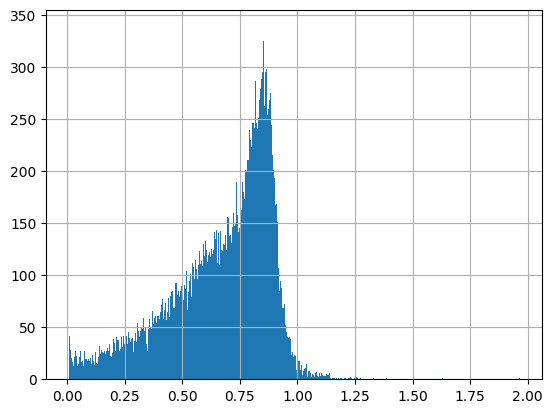

In [72]:
orig_measures_df["AUC"].hist(bins=1000)

In [78]:
# merge curvecurator and original fits
mapped_response_df = viability_df.merge(orig_measures_df, on=["cpd_name", "ccl_name"], how='left')
mapped_response_df

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,ccl_name,cpd_name,sample,drug,area_under_curve,AUC
0,CVCL_0006|387447,0.0,8.121074,10.000000,1.097185,0.031570,-4.985291,0.472640,0.039506,0.993924,...,CVCL_0006,387447,7.567035e-09,7.753043e-09,THP1,bortezomib,CVCL_0006,387447,3.31050,0.413813
1,CVCL_0007|387447,0.0,8.386980,10.000000,1.147691,0.010585,-6.561786,0.337758,0.085707,0.973699,...,CVCL_0007,387447,4.102228e-09,4.218800e-09,U937,bortezomib,CVCL_0007,387447,2.51780,0.314725
2,CVCL_0012|387447,0.0,8.577246,4.573292,1.030760,0.026085,-5.260615,0.225003,0.016225,0.998586,...,CVCL_0012,387447,2.647000e-09,2.713386e-09,LP1,bortezomib,CVCL_0012,387447,1.56290,0.195362
3,CVCL_0014|387447,0.0,8.526281,8.269879,1.043971,0.010244,-6.609083,0.239339,0.020866,0.998078,...,CVCL_0014,387447,2.976590e-09,3.014620e-09,RPMI8226,bortezomib,CVCL_0014,387447,1.62860,0.203575
4,CVCL_0024|387447,0.0,8.243077,3.748460,1.119518,0.016693,-5.903842,0.409407,0.170436,0.895521,...,CVCL_0024,387447,5.713767e-09,6.105049e-09,SCLC21H,bortezomib,CVCL_0024,387447,3.08140,0.385175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60752,CVCL_1662|100016,0.0,2.528659,0.560463,0.977548,0.000100,-0.524009,0.864628,0.056947,0.701450,...,CVCL_1662,100016,2.960337e-03,2.728323e-03,RMGI,zebularine,CVCL_1662,100016,6.03895,0.754869
60753,CVCL_1662|119607,0.0,3.613511,1.785789,0.894399,0.000100,-2.717681,0.711523,0.089469,0.905135,...,CVCL_1662,119607,2.434945e-04,2.132263e-04,RMGI,valdecoxib,CVCL_1662,119607,4.90615,0.613269
60754,CVCL_1662|216326,0.0,5.349522,10.000000,1.000023,0.931218,-0.102808,0.931982,0.047540,0.124025,...,CVCL_1662,216326,4.471758e-06,NaN,RMGI,lenalidomide,CVCL_1662,216326,6.53080,0.816350
60755,CVCL_1662|39562,0.0,3.375186,2.936334,0.933884,0.000100,-1.990078,0.847939,0.076599,0.893732,...,CVCL_1662,39562,4.215162e-04,4.016673e-04,RMGI,lonidamine,CVCL_1662,39562,5.91250,0.739062


<Axes: xlabel='AUC_curvecurator', ylabel='AUC'>

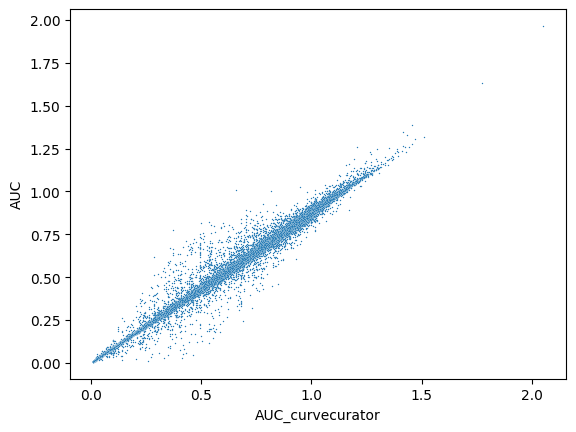

In [53]:
sns.scatterplot(mapped_response_df, x="AUC_curvecurator", y="AUC", s=1)

In [85]:
mapped_response_df.query("AUC<0.5")

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,ccl_name,cpd_name,sample,drug,area_under_curve,AUC
0,CVCL_0006|387447,0.0,8.121074,10.000000,1.097185,0.031570,-4.985291,0.472640,0.039506,0.993924,...,CVCL_0006,387447,7.567035e-09,7.753043e-09,THP1,bortezomib,CVCL_0006,387447,3.31050,0.413813
1,CVCL_0007|387447,0.0,8.386980,10.000000,1.147691,0.010585,-6.561786,0.337758,0.085707,0.973699,...,CVCL_0007,387447,4.102228e-09,4.218800e-09,U937,bortezomib,CVCL_0007,387447,2.51780,0.314725
2,CVCL_0012|387447,0.0,8.577246,4.573292,1.030760,0.026085,-5.260615,0.225003,0.016225,0.998586,...,CVCL_0012,387447,2.647000e-09,2.713386e-09,LP1,bortezomib,CVCL_0012,387447,1.56290,0.195362
3,CVCL_0014|387447,0.0,8.526281,8.269879,1.043971,0.010244,-6.609083,0.239339,0.020866,0.998078,...,CVCL_0014,387447,2.976590e-09,3.014620e-09,RPMI8226,bortezomib,CVCL_0014,387447,1.62860,0.203575
4,CVCL_0024|387447,0.0,8.243077,3.748460,1.119518,0.016693,-5.903842,0.409407,0.170436,0.895521,...,CVCL_0024,387447,5.713767e-09,6.105049e-09,SCLC21H,bortezomib,CVCL_0024,387447,3.08140,0.385175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60632,CVCL_2989|100016,0.0,5.252212,2.689566,0.999245,0.017548,-5.832297,0.091387,0.006592,0.999611,...,CVCL_2989,100016,5.594841e-06,5.666468e-06,KMS11,zebularine,CVCL_2989,100016,0.65383,0.081729
60687,CVCL_5031|100016,0.0,4.795174,4.849421,0.929449,0.237335,-2.075003,0.414675,0.069973,0.950933,...,CVCL_5031,100016,1.602603e-05,1.773593e-05,SNU175,zebularine,CVCL_5031,100016,2.91640,0.364550
60689,CVCL_5031|216326,0.0,5.458875,0.097911,0.999990,0.116189,-1.154465,0.500040,0.029864,0.966443,...,CVCL_5031,216326,3.476361e-06,5.176882e-05,SNU175,lenalidomide,CVCL_5031,216326,3.49890,0.437362
60697,CVCL_5098|100016,0.0,4.632868,2.280384,1.056376,0.071469,-3.794185,0.401740,0.069498,0.972341,...,CVCL_5098,100016,2.328799e-05,2.611284e-05,SNU81,zebularine,CVCL_5098,100016,2.87430,0.359287


In [91]:
mapped_response_df.to_csv("CTRPv1_for_drevalpy.csv")

## Final tweaks
- Kick out rows where CurveCurator failed
- Check out unmapped cell lines 
- Set EC50s outside the measured range to NaN
- Set IC50s outside 10*max/10**-1 min measured range to NaN
- Add min/max dosages to the dataframe

In [12]:
mapped_response_df = pd.read_csv("CTRPv1_for_drevalpy.csv")
mapped_response_df = mapped_response_df.drop(columns=["Unnamed: 0"])
mapped_response_df[mapped_response_df["cell_line_id"].isna()]

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,ccl_name,cpd_name,sample,drug,area_under_curve,AUC


In [13]:
# pEC50 = -log10(10^(-6) * dosis); allow 10^-1 to 10^2 times the min/max dose for IC50
drug_dosages = pd.read_csv("drug_dosages_CTRPv1.csv")
min_doses_pEC50 = {f'{row["cpd_name"]}|{row["ccl_name"]}': -np.log10(10**-6 * row["mindose"]) for index, row in drug_dosages.iterrows()}
max_doses_pEC50 = {f'{row["cpd_name"]}|{row["ccl_name"]}': -np.log10(10**-6 * row["maxdose"]) for index, row in drug_dosages.iterrows()}
min_doses_IC50 = {f'{row["cpd_name"]}|{row["ccl_name"]}': 10**-7 * row["mindose"] for index, row in drug_dosages.iterrows()}
max_doses_IC50 = {f'{row["cpd_name"]}|{row["ccl_name"]}': 10**-5 * row["maxdose"] for index, row in drug_dosages.iterrows()}

In [15]:
min_doses_M = mapped_response_df.apply(lambda x: 10 * min_doses_IC50[f"{x['cpd_name']}|{x['ccl_name']}"], axis=1)
max_doses_M = mapped_response_df.apply(lambda x: 0.1 * max_doses_IC50[f"{x['cpd_name']}|{x['ccl_name']}"], axis=1)
mapped_response_df["min_dose_M"] = min_doses_M
mapped_response_df["max_dose_M"] = max_doses_M

In [18]:
def plot_curve(df, index):
    front = df.loc[index, "Front"]
    back = df.loc[index, "Back"]
    pec50 = df.loc[index, "pEC50_curvecurator"]
    ec50 = df.loc[index, "EC50_curvecurator"]
    
    slope = df.loc[index, "Slope"]
    ic50 = df.loc[index, "IC50_curvecurator"]
    origAUC = df.loc[index, "AUC"]
    
    min_dosis = df.loc[index, "min_dose_M"]
    max_dosis = df.loc[index, "max_dose_M"]
    
    xvals = np.linspace(min_dosis*10**-2, max_dosis*10**2, 100000)
    xvals_logged = np.log10(xvals)
    y = (front - back) / (1 + 10 ** (slope * (xvals_logged + pec50))) + back
    plt.scatter(xvals, y, s=1)

    plt.axvline(ic50, color="red")
    plt.text(x=ic50, y=1.0, s='IC50 curvecurator', color='red')
    plt.axvline(ec50, color="orange")
    plt.text(x=ec50, y=0.6, s='EC50 curvecurator', color='orange')
    plt.axvline(x=min_dosis, color="green")
    plt.text(x=min_dosis, y=0.4, s='min dose [M]', color='green')
    plt.axvline(x=max_dosis, color="green")
    plt.text(x=max_dosis, y=0.4, s='max dose [M]', color='green')
    
    auc = df.loc[index, "AUC_curvecurator"]
    plt.title(f"AUC: {auc}, Original AUC: {origAUC}")

    plt.axhline(0.5, linestyle='--', color='black')
    plt.xscale('log')
    plt.xlim(min_dosis*10**-2, max_dosis*10**2)
    plt.ylim(0, 2)

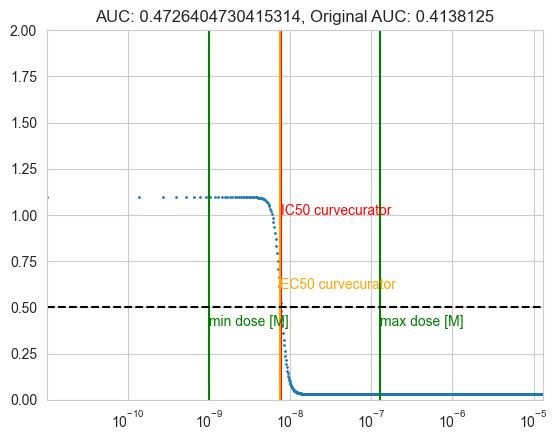

In [19]:
plot_curve(mapped_response_df, 0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


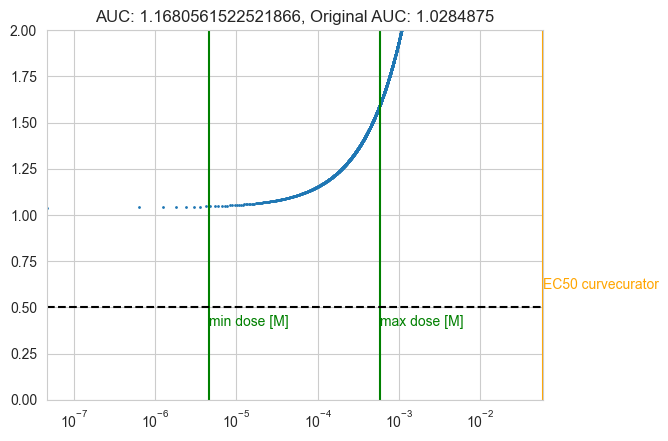

In [20]:
# CurveCurator caps the EC50s at 10**2 * max dose / 10**-2 * min dose
index = mapped_response_df.query("Name == 'CVCL_0526|100016'").index[0]
plot_curve(mapped_response_df, index=index)

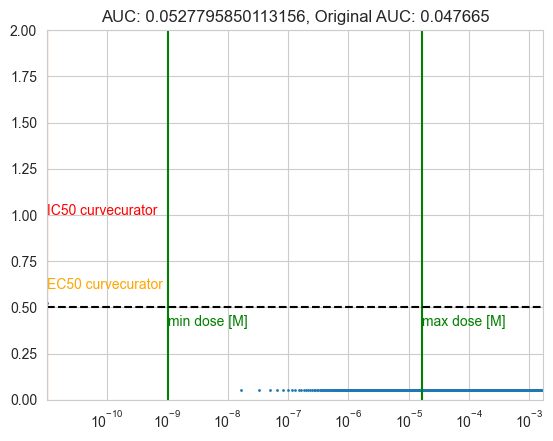

In [21]:
# CurveCurator caps the EC50s at 10**2 * max dose / 10**-2 * min dose
index = mapped_response_df.query("Name == 'CVCL_2989|9854230'").index[0]
plot_curve(mapped_response_df, index=index)

In [22]:
num_pEC50s_nan = mapped_response_df["pEC50_curvecurator"].isna().sum()
num_ic50s_nan = mapped_response_df["IC50_curvecurator"].isna().sum()
new_pEC50s = mapped_response_df.apply(lambda x: x["pEC50_curvecurator"] if min_doses_pEC50[f"{x['cpd_name']}|{x['ccl_name']}"] >= x["pEC50_curvecurator"] >= max_doses_pEC50[f"{x['cpd_name']}|{x['ccl_name']}"] else np.nan, axis=1)
new_IC50s = mapped_response_df.apply(lambda x: x["IC50_curvecurator"] if min_doses_IC50[f"{x['cpd_name']}|{x['ccl_name']}"] <= x["IC50_curvecurator"] <= max_doses_IC50[f"{x['cpd_name']}|{x['ccl_name']}"] else np.nan, axis=1)

In [23]:
mapped_response_df["pEC50_curvecurator"] = new_pEC50s
mapped_response_df["IC50_curvecurator"] = new_IC50s
print(f"From {num_pEC50s_nan} to {mapped_response_df['pEC50_curvecurator'].isna().sum()} NaN pEC50s / {len(mapped_response_df)}")
print(f"From {num_ic50s_nan} to {mapped_response_df['IC50_curvecurator'].isna().sum()} NaN IC50s / {len(mapped_response_df)}")

From 0 to 15235 NaN pEC50s / 60757
From 20800 to 23287 NaN IC50s / 60757


In [24]:
mapped_response_df["LN_IC50_curvecurator"] = np.log(10**6 * mapped_response_df["IC50_curvecurator"].to_numpy())

<Axes: xlabel='LN_IC50_curvecurator', ylabel='Count'>

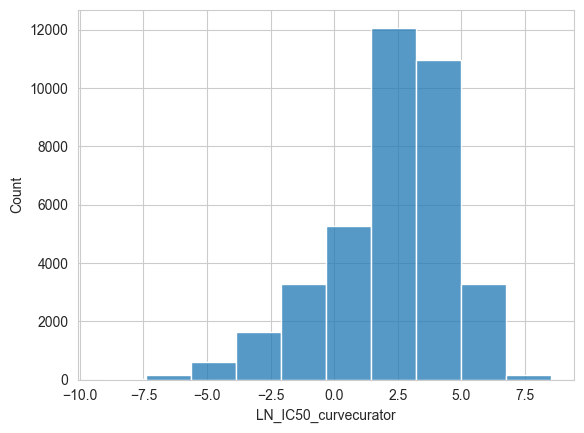

In [25]:
sns.histplot(mapped_response_df["LN_IC50_curvecurator"], bins=10)

<Axes: xlabel='pEC50_curvecurator', ylabel='Count'>

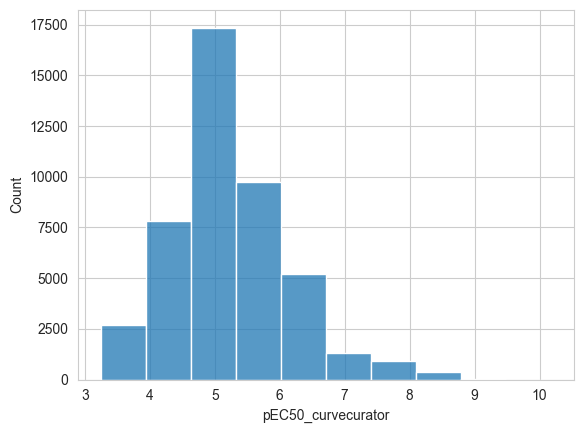

In [26]:
sns.histplot(mapped_response_df["pEC50_curvecurator"], bins=10)

<Axes: xlabel='AUC_curvecurator', ylabel='Count'>

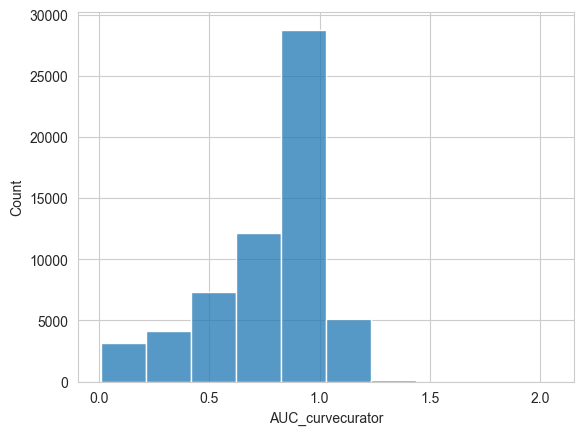

In [27]:
sns.histplot(mapped_response_df["AUC_curvecurator"], bins=10)

In [28]:
# map all names to cellosaurus main names
from utils.convert_to_cello import create_cl_dict
cello_mapping = pd.read_csv("../../mapping/cellosaurus_01_2024.csv")
# replace all NaN values with empty strings
cello_mapping = cello_mapping.fillna("")
# create cellosaurus dictionary
cellosaurus_ac_dict, cellosaurus_sy_dict, species_dict, cello_ac_to_id_dict = create_cl_dict(cello_mapping)

Creating cellosaurus dictionary ...


In [30]:
main_names = [cello_ac_to_id_dict[row["cell_line_id"]] for _, row in mapped_response_df.iterrows()]
mapped_response_df["cell_line_name"] = main_names
mapped_response_df = mapped_response_df.set_index(["cell_line_id", "cell_line_name", "drug_id", "cpd_name"])

In [31]:
mapped_response_df.to_csv("CTRPv1.csv")

In [32]:
mapped_response_df

Name  \
cell_line_id cell_line_name drug_id cpd_name                         
CVCL_0006    THP-1          387447  bortezomib    CVCL_0006|387447   
CVCL_0007    U-937          387447  bortezomib    CVCL_0007|387447   
CVCL_0012    LP-1           387447  bortezomib    CVCL_0012|387447   
CVCL_0014    RPMI-8226      387447  bortezomib    CVCL_0014|387447   
CVCL_0024    SCLC-21H       387447  bortezomib    CVCL_0024|387447   
...                                                            ...   
CVCL_1662    RMG-I          100016  zebularine    CVCL_1662|100016   
                            119607  valdecoxib    CVCL_1662|119607   
                            216326  lenalidomide  CVCL_1662|216326   
                            39562   lonidamine     CVCL_1662|39562   
                            4788    phloretin       CVCL_1662|4788   

                                                  SignalQuality  \
cell_line_id cell_line_name drug_id cpd_name                      
CVCL_0006    THP-1          387447  bortezomib              0.0   
CVCL_0007    U-937          387447  bortezomib              0.0   
CVCL_0012    LP-1           387447  bortezomib              0.0   
CVCL_0014    RPMI-8226      387447  bortezomib              0.0   
CVCL_0024    SCLC-21H       387447  bortezomib              0.0   
...                                                         ...   
CVCL_1662    RMG-I          100016  zebularine              0.0   
                            119607  valdecoxib              0.0   
                            216326  lenalidomide            0.0   
                            39562   lonidamine              0.0   
                            4788    phloretin               0.0   

                                                  pEC50_curvecurator  \
cell_line_id cell_line_name drug_id cpd_name                           
CVCL_0006    THP-1          387447  bortezomib              8.121074   
CVCL_0007    U-937          387447  bortezomib              8.386980   
CVCL_0012    LP-1           387447  bortezomib              8.577246   
CVCL_0014    RPMI-8226      387447  bortezomib              8.526281   
CVCL_0024    SCLC-21H       387447  bortezomib              8.243077   
...                                                              ...   
CVCL_1662    RMG-I          100016  zebularine                   NaN   
                            119607  valdecoxib              3.613511   
                            216326  lenalidomide                 NaN   
                            39562   lonidamine              3.375186   
                            4788    phloretin               3.392260   

                                                      Slope     Front  \
cell_line_id cell_line_name drug_id cpd_name                            
CVCL_0006    THP-1          387447  bortezomib    10.000000  1.097185   
CVCL_0007    U-937          387447  bortezomib    10.000000  1.147691   
CVCL_0012    LP-1           387447  bortezomib     4.573292  1.030760   
CVCL_0014    RPMI-8226      387447  bortezomib     8.269879  1.043971   
CVCL_0024    SCLC-21H       387447  bortezomib     3.748460  1.119518   
...                                                     ...       ...   
CVCL_1662    RMG-I          100016  zebularine     0.560463  0.977548   
                            119607  valdecoxib     1.785789  0.894399   
                            216326  lenalidomide  10.000000  1.000023   
                            39562   lonidamine     2.936334  0.933884   
                            4788    phloretin      4.719809  0.896248   

                                                      Back  FoldChange  \
cell_line_id cell_line_name drug_id cpd_name                             
CVCL_0006    THP-1          387447  bortezomib    0.031570   -4.985291   
CVCL_0007    U-937          387447  bortezomib    0.010585   -6.561786   
CVCL_0012    LP-1           387447  bortezomib    0.026085   -5.260615   
CVCL_0014    RPMI-8226